<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="https://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/llibre-estil/logo-UOC-masterbrand-vertical.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PEC1</p>
<p style="margin: 0; text-align:right;">2023-2 · Máster universitario en Ciencia de Datos (Data Science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia i Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PAC4 Modelos generativos

**Títol:** GAN condicionada

**Descripció:** Construcción i entrenamiento de una GAN condicionada a la clase.

Las redes generativas adversarias (GANs) nos permiten generar datos de imágenes, vídeos o audio a partir de una entrada aleatoria. Normalmente, la entrada aleatoria se muestrea de una distribución normal, antes de pasar por una serie de transformaciones que la convierten en algo plausible (imagen, vídeo, audio, etc.).

Sin embargo, un simple DCGAN no nos permite controlar la apariencia (por ejemplo, la clase) de las muestras que estamos generando. Por ejemplo, con una GAN que genera dígitos manuscritos, un simple DCGAN no permitiría elegir la clase de los dígitos que estamos generando. Para poder controlar lo que generamos, necesitamos acondicionar la salida de la GAN a una entrada semántica, como la clase de una imagen.

En esta PEC, vamos a construir una GAN Condicional que pueda generar dígitos manuscritos condicionados a una clase determinada.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Pregunta [0,5 pts.]:</strong> ¿Qué aplicaciones de utilidad puede tener un modelo como éste?     
</div>

Supongamos que estás tratando con un conjunto de datos de imágenes desequilibrado, y querrías recopilar más ejemplos para la clase desequilibrada para equilibrar el conjunto de datos. La recopilación de datos puede ser un proceso costoso por sí mismo. En lugar de esto, podría entrenar una GAN Condicional y utilizarla para generar imágenes nuevas para la clase que necesita equilibrio.
Dado que el generador aprende a asociar las muestras generadas con las etiquetas de clase, sus representaciones también pueden utilizarse para otras tareas aguas abajo.

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

## 0. Importaciones necesarias

In [ ]:
import keras

from keras import layers
from keras import ops
from tensorflow_docs.vis import embed
import tensorflow as tf
import numpy as np
import imageio
from sklearn.preprocessing import OneHotEncoder

2024-05-19 08:18:35.774114: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-19 08:18:35.774920: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 08:18:35.810112: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 08:18:35.956473: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 08:18:36.855844: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

## 1. Definición de constantes e hiperparámetros

In [ ]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Pregunta [0,5 pts.]:</strong> ¿Para qué sirve la variable `latent_dim`?
    
</div>

Esta variable es la que determina la dimensión que tendrá posteriormente el vector aleatorio de variables aleatorias que servirá como base de entrada para la generación aleatoria de muestras.

## 2. Carga del dataset i preprocessat

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici [1,5 pts.]:</strong> Descarga i carga lo datos:
</div>

Descarga el conjunto de datos de la web:
https://www.kaggle.com/datasets/jordidelatorreuoc/handwritten-digits-with-writer-characteristics/data

Utilizaremos la versión de 28x28. Analiza el contenido del conjunto de datos. Identifica las variables de interés, imágenes en formato 28x28 y etiquetas (digitos) y cárgalas en un dataset de tensorflow. Las variables deben cargarse, normalizarse a [0,1]. Las clases deben vectorizarse, p.e. clase 9 a [0, 0, 0, 0, 0, 0 ,0 ,0, 1] y las imágenes deben tener las dimensiones correctas para ser procesadas posteriormente con tensorflow.

Las dimensiones de salida deberían ser:

Shape of images: (13580, 28, 28, 1)

Shape of labels: (13580, 10)

Se espera como salida del proceso una variable `dataset` del tipo `tf.data.Dataset`

In [ ]:
# Load data from NDW+ directory
images_path = './HDW+/Images(28x28).npy'
labels_path = './HDW+/WriterInfo.npy'

# Load images and labels
images = np.load(images_path)
labels_and_info = np.load(labels_path)

# Extract labels from labels_and_info
labels = labels_and_info[:, 0]  # Assuming labels are in the first position

# Scale the pixel values to [0, 1] range
images = images.astype("float32") / 255.0

# One-hot encode the labels
encoder = OneHotEncoder(categories='auto', sparse=False)
labels_onehot = encoder.fit_transform(labels.reshape(-1, 1))

# Reshape images to include channel dimension
images = np.expand_dims(images, axis=-1)

# Create tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((images, labels_onehot))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of images: {images.shape}")
print(f"Shape of labels: {labels_onehot.shape}")

/home/jordi/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Shape of images: (13580, 28, 28, 1)
Shape of labels: (13580, 10)


2024-05-19 08:18:39.605948: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-19 08:18:39.606565: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## 3. Cálculo del número de canales de entrada para generador y discriminador.

En una GAN regular (no condicional), empezamos por muestrear ruido (de una dimensión fija) de una distribución normal. En nuestro caso, también debemos tener en cuenta las etiquetas de clase. Deberemos añadir el número de clases a los canales de entrada del generador (entrada de ruido) y también al discriminador (entrada de la imagen generada).

In [ ]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

138 11


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Pregunta [0,5 pts.]:</strong> Justifica para qué sirven las variables anteriores y cuál es la necesidad de cada una de ellas
   
</div>

Son el número de entradas de generador y discriminador. En una CGAN en el generador se alimenta no sólo el vector de variables latentes sino también la clase de la imagen que se desea generar. Por lo que respecta al discriminador debe ser capaz de identificar entre imagen real y generada pero también si es de la clase indicada.

## 4. Implementación del Generador y del Discriminador

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Pregunta [3 pts.]:</strong>
Implementa el modelo de Deep Learning utilizando la librería de tensorflow keras. El objetivo es construir un discriminador y un generador que formen parte de una red antagonista generativa. Como ya sabes, el discriminador debe ser capaz de distinguir entre imágenes reales y las generadas por el generador, mientras que el generador debe crear imágenes que el discriminador no pueda distinguir como falsas. Utiliza las capas de convolución, activación y densas para construir los modelos de forma que cumplan con las dimensiones especificadas de las entradas y salidas. Asegúrate de gestionar adecuadamente las dimensiones de las capas convolucionales y transconvolucionales para obtener las dimensiones de salida deseadas. Ayúdate de la búsqueda online para generar tu propuesta. Para que el resto de código funcione correctamente las variables asociadas al discriminador y al generador resultantes deberán llamarse `generator` y `discriminator`.
</div>

In [ ]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((28, 28, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(7 * 7 * generator_in_channels),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Reshape((7, 7, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

## 5. Implementación de la clase model `ConditionalGAN`

En base a la definición de la clase siguiente:

In [ ]:

class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        real_images, one_hot_labels = data

        # apartat 1
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = ops.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = ops.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # apartat 2
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # apartat 3
        generated_images = self.generator(random_vector_labels)

        # apartat 4
        fake_image_and_labels = ops.concatenate(
            [generated_images, image_one_hot_labels], -1
        )
        # apartat 5
        real_image_and_labels = ops.concatenate([real_images, image_one_hot_labels], -1)

        # apartat 6
        combined_images = ops.concatenate(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # apartat 7
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )

        # apartat 8
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # apartat 9
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # apartat 10
        misleading_labels = ops.zeros((batch_size, 1))

        # apartat 11
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = ops.concatenate(
                [fake_images, image_one_hot_labels], -1
            )
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # apartat 12
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Pregunta [2,5 pts.]</strong>
Rellena la la tabla que sigue indicando lo que significa cada uno de los apartados del código::      
</div>

| Apartado    | Descripción  |
|-------------|-------------|
| Apartado 1  | Convierte las etiquetas one-hot en un formato compatible con las imágenes, expandiéndolas y repitiéndolas para coincidir con el tamaño de las imágenes. |
| Apartado 2  | Genera vectores latentes aleatorios y concatena estos vectores con las etiquetas one-hot para formar vectores de entrada para el generador. |
| Apartado 3  | Genera imágenes falsas utilizando el generador a partir de los vectores latentes y etiquetas. |
| Apartado 4  | Concatena las imágenes generadas con las etiquetas de las imágenes, preparando las imágenes falsas y etiquetas para el discriminador. |
| Apartado 5  | Concatena las imágenes reales con las etiquetas de las imágenes, preparando las imágenes reales y etiquetas para el discriminador. |
| Apartado 6  | Combina las imágenes falsas con etiquetas y las imágenes reales con etiquetas en un solo lote para el discriminador. |
| Apartado 7  | Crea etiquetas para el discriminador, donde las imágenes reales se marcan con 1s y las imágenes falsas con 0s. |
| Apartado 8  | Calcula la pérdida del discriminador utilizando las imágenes combinadas y sus etiquetas, y actualiza los pesos del discriminador aplicando gradientes. |
| Apartado 9  | Genera nuevos vectores latentes aleatorios y los concatena con las etiquetas one-hot para formar nuevos vectores de entrada para el generador. |
| Apartado 10 | Crea etiquetas engañosas para el generador, donde todas las imágenes falsas se marcan con 0s (esperando que el discriminador clasifique incorrectamente las imágenes falsas como reales). |
| Apartado 11 | Calcula la pérdida del generador utilizando imágenes falsas y etiquetas engañosas, y actualiza los pesos del generador aplicando gradientes. |
| Apartado 12 | Actualiza los contadores de pérdida del generador y del discriminador y devuelve los valores de las pérdidas actuales. |



## 6. Entrenamiento de la GAN condicional

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Pregunta [0,5 pts.]:</strong> Entrena la red mediante el código que sigue. A continuación, ejecuta el código que permitirá el uso de la red entrenada para generar diferentes instancias de clases diferentes y construir un GIF animado que muestra la transición entre las imágenes de diferente clase. No es necesario implementar nada. Si los apartados anteriores se han implementado correctamente debería ejecutarse sin problemas.
</div>

In [ ]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

cond_gan.fit(dataset, epochs=20)

Epoch 1/20


2024-05-19 08:18:41.414831: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'StatefulPartitionedCall/gradient_tape/discriminator_3/leaky_re_lu_1/LeakyRelu/LeakyReluGrad' exist for missing node 'StatefulPartitionedCall/discriminator_3/conv2d_1/add'.


213/213 ━━━━━━━━━━━━━━━━━━━━ 27s 118ms/step - d_loss: 0.5776 - g_loss: 0.8644
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 25s 119ms/step - d_loss: 0.4885 - g_loss: 1.1352
Epoch 3/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 24s 114ms/step - d_loss: 0.6063 - g_loss: 0.8673
Epoch 4/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 26s 121ms/step - d_loss: 0.6197 - g_loss: 0.8871
Epoch 5/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 27s 129ms/step - d_loss: 0.6385 - g_loss: 0.8448
Epoch 6/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 27s 128ms/step - d_loss: 0.6279 - g_loss: 0.8442
Epoch 7/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 27s 128ms/step - d_loss: 0.6083 - g_loss: 0.8820
Epoch 8/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 27s 128ms/step - d_loss: 0.5569 - g_loss: 1.0009
Epoch 9/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 31s 147ms/step - d_loss: 0.5168 - g_loss: 1.1148
Epoch 10/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 32s 148ms/step - d_loss: 0.5172 - g_loss: 1.1383
Epoch 11/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 31s 147ms/step - d_loss: 0.4541 - g_loss: 1.3110
Epoch 12/20
213/213 ━━━━━━━━━━

## 7. Interpolación entre clases utilitzando el generador que hemos entrenado

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px sólido #7C9DBF; padding: 0.5em;">
<strong>Ejercicio [0,5 pts.]:</strong>
Por último, ejecuta el siguiente código. Si el entrenamiento se ha realizado correctamente debería ser capaz de generar interpolaciones de imágenes entre imágenes generadas de diferentes clases.
</div>

Se podría mejorar el rendimiento de ese modelo con recetas como WGAN-GP. La generación condicional también se utiliza ampliamente en muchas arquitecturas modernas de generación de imágenes como VQ-GANs y DALL-E, entre otras.

In [ ]:
# extraemos el generador entrenado de nuestro GAN Condicional
trained_gen = cond_gan.generator

# elige el número de imágenes intermedias que se generarían entre la interpolación + 2 (imágenes inicial y final)
num_interpolation = 9

# ruido aleatorio para la interpolación
interpolation_noise = keras.random.normal(shape=(1, latent_dim))
interpolation_noise = ops.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = ops.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # convierte las etiquetas inicial y final a vectores one-hot
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = ops.cast(first_label, "float32")
    second_label = ops.cast(second_label, "float32")

    # calcula el vector de interpolación entre las dos etiquetas
    percent_second_label = ops.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = ops.cast(percent_second_label, "float32")
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # combina el ruido y las etiquetas i ejecuta la inferencia con el generador
    noise_and_labels = ops.concatenate([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake


start_class = 2  # primera clase de interpolación
end_class = 6  # última clase de interpolación

fake_images = interpolate_class(start_class, end_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Mostramos ruido de una distribución normal y después lo repetimos para num_interpolation veces y damos forma al resultado en consecuencia. A continuación lo distribuimos uniformemente para num_interpolation con las etiquetas presentes proporcionalmente.


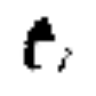

In [ ]:
fake_images *= 255.0
converted_images = fake_images.astype(np.uint8)
converted_images = ops.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("animation.gif", converted_images[:, :, :, 0], fps=1)
embed.embed_file("animation.gif")

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Pregunta [0,5 pts.]</strong>
Comentar los resultados de los puntos 6 y 7:     
</div>